In [1]:
# load libraries
import pandas as pd
import numpy as np
import rasterio
import rasterio.plot
from rasterio.plot import plotting_extent
import pyproj
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
from glob import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import os

# print current working directory
os.getcwd()

'/Users/chasedawson/dev/uva_equity_center/climate_equity'

In [2]:
# read all .TIF files in specified directory
landsat_path = glob(
    os.path.join(
        "bulk_orders",
        "Bulk Order Landsat 8 C2 L2",
        "Landsat 8 OLI_TIRS C2 L2",
        "LC08_L2SP_016034_20200906_20200918_02_T1",
        "LC08_L2SP_016034_20200906_20200918_02_T1_*.TIF",
    )
)
landsat_path.sort()
array_stack, meta_data = es.stack(landsat_path, nodata=-9999)

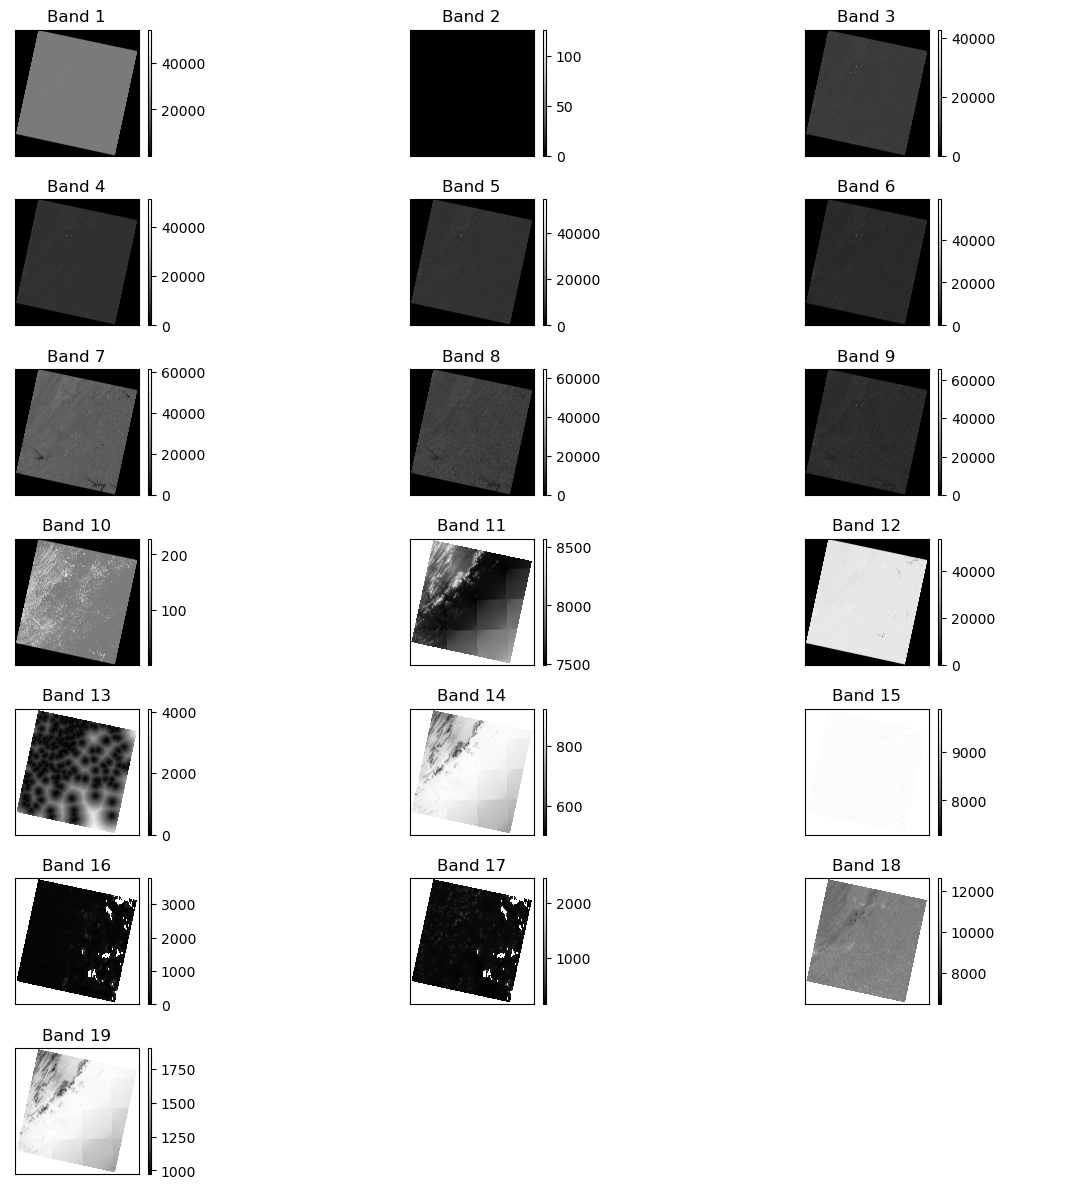

In [3]:
# it does look like there's a good bit of cloud coverage on this day, might need to try a difference scene
ep.plot_bands(array_stack)
plt.show()

In [4]:
# just open surface temperature band
st_path = os.path.join(
        "bulk_orders",
        "Bulk Order Landsat 8 C2 L2",
        "Landsat 8 OLI_TIRS C2 L2",
        "LC08_L2SP_016034_20200906_20200918_02_T1",
        "LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10.TIF",    
    )

with rasterio.open(st_path) as src:
    # read data
    st_data = src.read()
    
    # create plotting extent
    st_data_plotting_extent = plotting_extent(src)
    
    # print metadata
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7601, 'height': 7741, 'count': 1, 'crs': CRS.from_epsg(32617), 'transform': Affine(30.0, 0.0, 576885.0,
       0.0, -30.0, 4265115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


In [5]:
st_data.shape

(1, 7741, 7601)

In [6]:
# (leftmost coord, rightmost coord, bottom coord, top coord)
st_data_plotting_extent

(576885.0, 804915.0, 4032885.0, 4265115.0)

In [7]:
src.bounds

BoundingBox(left=576885.0, bottom=4032885.0, right=804915.0, top=4265115.0)

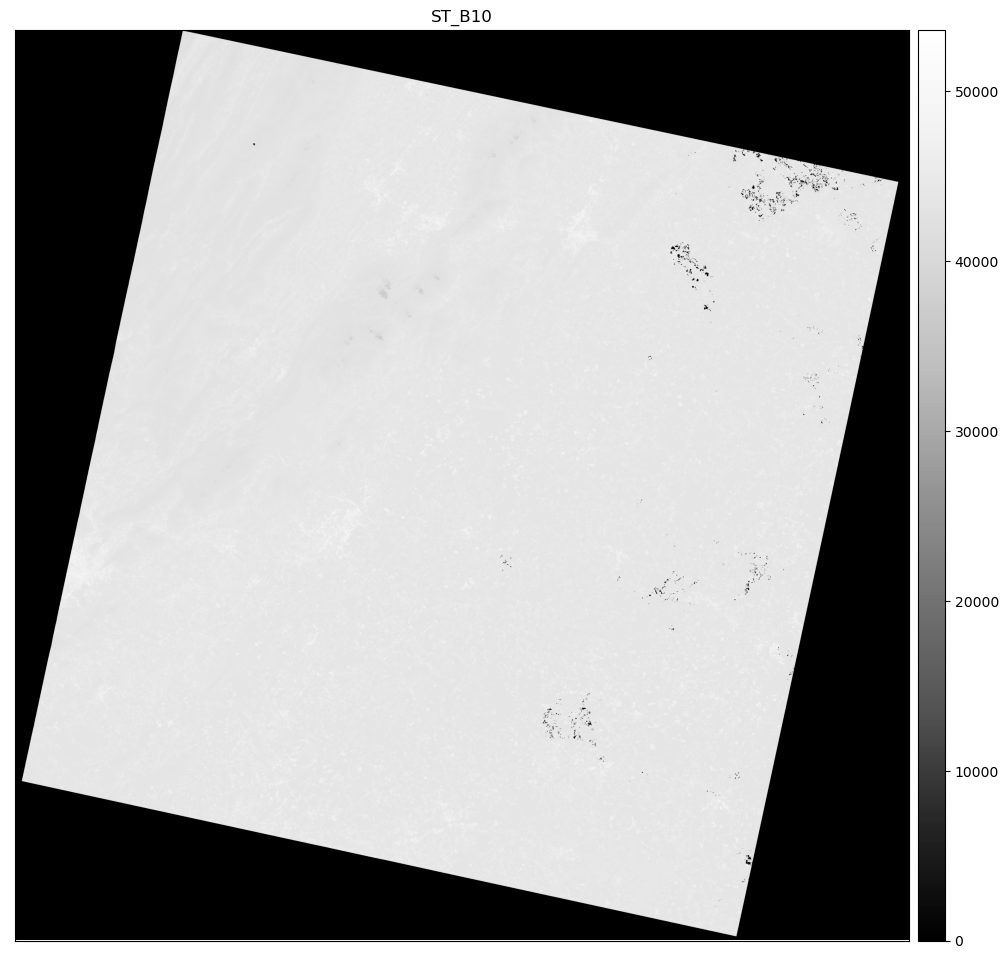

In [8]:
# plotting the surface temperature band
ep.plot_bands(st_data, title=["ST_B10"])
plt.show()

In [9]:
# read in shpfile containing us state borders
states = gpd.read_file('cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."


In [10]:
# convert states to crs of Landsat 8 data
states = states.to_crs(src.crs)

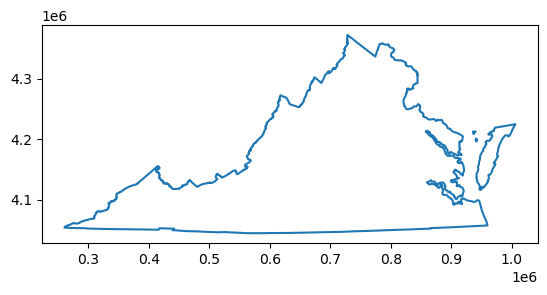

In [11]:
va = states[states.STUSPS == "VA"]
va.boundary.plot()
plt.show()

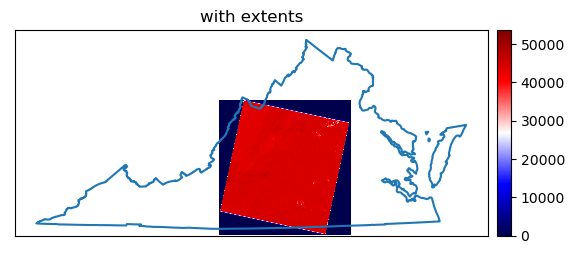

In [12]:
# this doesn't look quite right, i'm wondering what the cloud coverage was for this picture?
f, ax = plt.subplots()
ep.plot_bands(st_data, ax=ax, title="with extents", extent=st_data_plotting_extent, cmap="seismic")
va.boundary.plot(ax=ax)
plt.show()

In [13]:
# open cville shapefile
cville = gpd.read_file('municipal_boundary_area/municipal_boundary_area_09_03_2020.shp')
cville.head()

,FID_MASK,ID,SHAPE_area,SHAPE_len,geometry
0,-1,0,3.050647e+08,106729.765984,"POLYGON Z ((11497879.720 3908613.310 0.000, 11..."


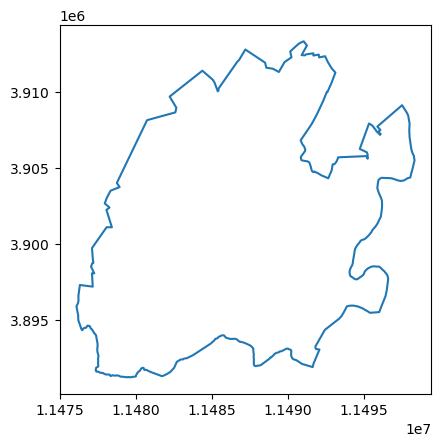

In [14]:
cville.boundary.plot()
plt.show()

In [15]:
cville = cville.to_crs(src.crs)

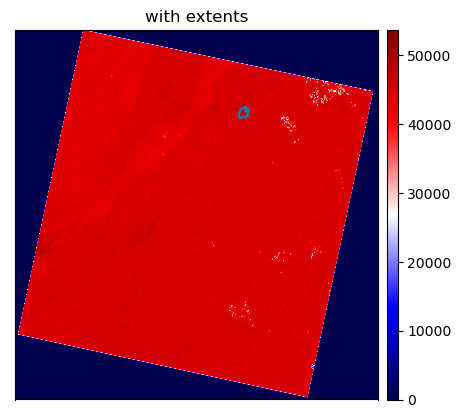

In [16]:
f, ax = plt.subplots()
ep.plot_bands(st_data, ax=ax, title="with extents", extent=st_data_plotting_extent, cmap="seismic")
cville.boundary.plot(ax=ax)
plt.show()

In [17]:
# zoom into cville
cville.total_bounds

array([ 717356.16659692, 4209810.21066371,  724071.58569606,
       4216658.37284727])

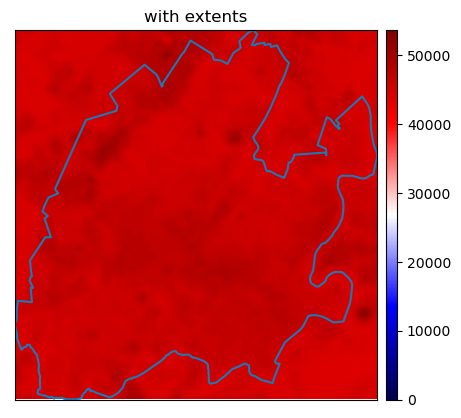

In [18]:
f, ax = plt.subplots()

# get x, y limits to just zoom into cville
xlim = ([cville.total_bounds[0], cville.total_bounds[2]])
ylim = ([cville.total_bounds[1], cville.total_bounds[3]])

ep.plot_bands(st_data, ax=ax, title="with extents", extent=st_data_plotting_extent, cmap="seismic")
cville.boundary.plot(ax=ax)

# set x, y limits on plot
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [19]:
src.crs

CRS.from_epsg(32617)

In [20]:
# write cville with crs matching landsat 8 raster data 
cville.to_file('crs_espg_32617/cville.shp')

In [21]:
from rasterstats import zonal_stats

path_to_tif = os.path.join(
        "bulk_orders",
        "Bulk Order Landsat 8 C2 L2",
        "Landsat 8 OLI_TIRS C2 L2",
        "LC08_L2SP_016034_20200906_20200918_02_T1",
        "LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10.TIF",    
    )

path_to_shp = os.path.join(
    'crs_espg_32617',
    'cville.shp',
)

zstats = zonal_stats(path_to_shp, path_to_tif, stats='min median max')[0] # if you get 'None' for stat value, make sure the files are saved
# with the same CRS otherwise rasterstats may be unable to compare them

zstats

{'min': 43877.0, 'max': 50667.0, 'median': 45862.0}

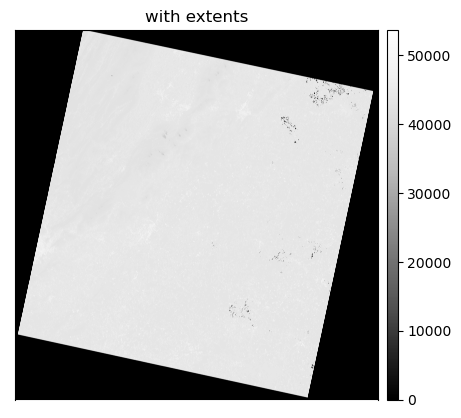

In [22]:
f, ax = plt.subplots()

# get x, y limits to just zoom into cville
xlim = ([cville.total_bounds[0], cville.total_bounds[2]])
ylim = ([cville.total_bounds[1], cville.total_bounds[3]])

# im = ax.imshow(st_data.squeeze())
# ep.colorbar(im)

ep.plot_bands(st_data, ax=ax, title="with extents", extent=st_data_plotting_extent, cbar=True)
# cville.boundary.plot(ax=ax)

# set x, y limits on plot
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

plt.show()

# set limit on colorbar
# plt.clim(zstats['min'], zstats['max'])
# plt.colorbar()

In [23]:
# References
# [Crop Spatial Raster Data with a Shapefile in Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/)